In [1]:
# !pip install matplotlib

In [1]:
#Import required library
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [4]:
#Directory of the dataset
DATA_DIR = 'C:/Users/SDP87/Documents/Guvi Projects/5.Brain Tumor Image Classification/Brain Tumor Image Classification/Images'

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR,"test")

In [5]:
#Importing the dataset

# Keras's ImageDataGenerator simplifies data loading and augmentation in one step.
# It automatically handles resizing and batching.

train_datagen = ImageDataGenerator(rotation_range=20,
                                    horizontal_flip=True,
                                    rescale=1./255,
                                    brightness_range=[0.8, 1.2])

test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(TRAIN_DIR,
                                               target_size = (224,224),
                                               batch_size =  16,
                                               class_mode = 'categorical')

validation_data = train_datagen.flow_from_directory(VAL_DIR,
                                                    target_size =(224,224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical')

test_data = test_datagen.flow_from_directory(TEST_DIR,
                                             target_size=(224,224),
                                             batch_size=16,
                                             class_mode='categorical',
                                             shuffle=False)
class_names = train_data.class_indices.keys()
print("Classes in dataset : ",class_names)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.
Classes in dataset :  dict_keys(['glioma', 'meningioma', 'no_tumor', 'pituitary'])


In [6]:
#Function for Custom CNN Model
def build_custom_cnn_model():
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters=16,kernel_size=(5,5),activation='relu',padding='same',input_shape= (224,224,3)))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(layers.Conv2D(filters=32,kernel_size=(5,5),activation='relu',padding='same'))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2,2)))
    cnn_model.add(layers.Conv2D(filters=64,kernel_size=(5,5),activation='relu',padding='same'))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(layers.Conv2D(filters=128,kernel_size=(5, 5),activation='relu',padding='same'))
    cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(128, activation='relu'))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(4, activation='softmax'))
    return cnn_model

In [7]:
def build_transfer_model(base_model_class):
    base_model = base_model_class(input_shape=(224,224,3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the convolutional base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation='softmax')
    ])
    return model

In [8]:
# 5. Training and Evaluation Function
# ---
def train_and_evaluate(model, model_name, train_gen, val_gen, test_gen, epochs):
    """Compiles, trains, and evaluates a given Keras model."""
    print(f"\n--- Training {model_name} ---")

    # Define a unique model path for each model
    model_path = f"models/{model_name.replace(' ', '_')}_best_model.h5"


    # Keras simplifies the process with model.compile and model.fit
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model_history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
            ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1)
        ]
    )

    # 6. Visualization
    # ---
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['loss'], label='Training Loss')
    plt.plot(model_history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_loss_plot.png')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['accuracy'], label='Training Accuracy')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{model_name}_accuracy_plot.png')

    plt.tight_layout()
    plt.show()


    # 7. Test Evaluation and Reporting
    # ---
    print(f"\n--- Evaluating {model_name} on Test Set ---")
    model.load_weights(model_path) # Load the best saved weights
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"\nTest Accuracy: {test_acc*100:.2f}%")

    # Get predictions for classification report and confusion matrix
    predictions = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



--- Training Custom CNN ---
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.4973 - loss: 1.1726
Epoch 1: val_loss improved from inf to 0.86230, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.4981 - loss: 1.1713 - val_accuracy: 0.6653 - val_loss: 0.8623
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.6727 - loss: 0.8258
Epoch 2: val_loss improved from 0.86230 to 0.63925, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 348ms/step - accuracy: 0.6728 - loss: 0.8255 - val_accuracy: 0.7430 - val_loss: 0.6393
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7432 - loss: 0.6457
Epoch 3: val_loss improved from 0.63925 to 0.63174, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.7432 - loss: 0.6458 - val_accuracy: 0.7390 - val_loss: 0.6317
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.7812 - loss: 0.5882
Epoch 4: val_loss improved from 0.63174 to 0.51845, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 347ms/step - accuracy: 0.7812 - loss: 0.5881 - val_accuracy: 0.8048 - val_loss: 0.5184
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8130 - loss: 0.4957
Epoch 5: val_loss did not improve from 0.51845
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.8131 - loss: 0.4958 - val_accuracy: 0.8008 - val_loss: 0.5537
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8433 - loss: 0.4519
Epoch 6: val_loss improved from 0.51845 to 0.47690, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 346ms/step - accuracy: 0.8432 - loss: 0.4520 - val_accuracy: 0.8247 - val_loss: 0.4769
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8592 - loss: 0.4039
Epoch 7: val_loss did not improve from 0.47690
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.8591 - loss: 0.4042 - val_accuracy: 0.8307 - val_loss: 0.4805
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8549 - loss: 0.3913
Epoch 8: val_loss improved from 0.47690 to 0.44232, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 347ms/step - accuracy: 0.8548 - loss: 0.3914 - val_accuracy: 0.8466 - val_loss: 0.4423
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8710 - loss: 0.3464
Epoch 9: val_loss improved from 0.44232 to 0.39142, saving model to models/Custom_CNN_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.8710 - loss: 0.3464 - val_accuracy: 0.8466 - val_loss: 0.3914
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8720 - loss: 0.3243
Epoch 10: val_loss did not improve from 0.39142
106/106 ━━━━━━━━━━━━━━━━━━━━ 37s 345ms/step - accuracy: 0.8719 - loss: 0.3244 - val_accuracy: 0.8685 - val_loss: 0.4121
Restoring model weights from the end of the best epoch: 9.


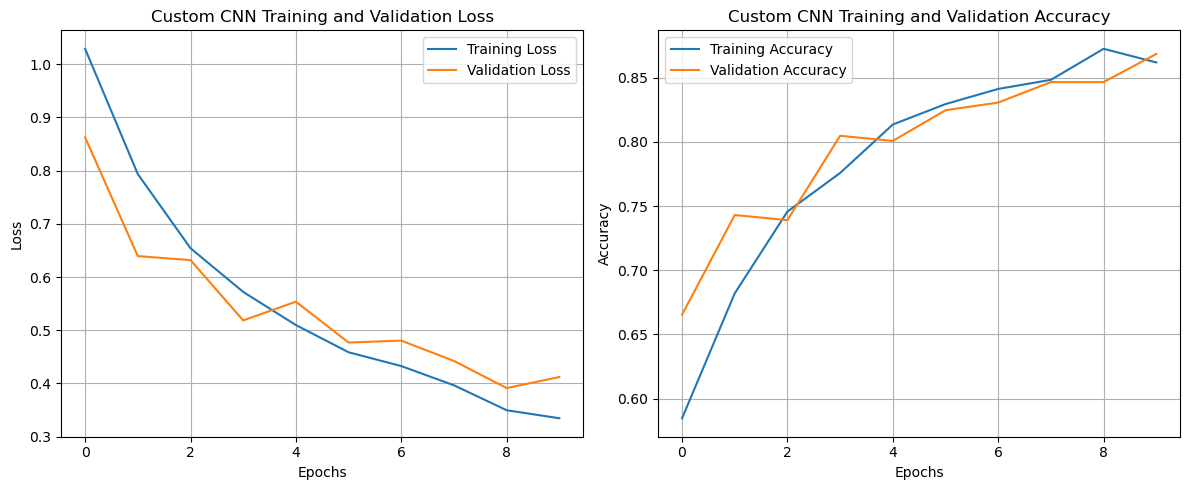


--- Evaluating Custom CNN on Test Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8107 - loss: 0.4023

Test Accuracy: 86.18%
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.82      0.89        80
  meningioma       0.77      0.75      0.76        63
    no_tumor       0.77      0.94      0.84        49
   pituitary       0.93      0.98      0.95        54

    accuracy                           0.86       246
   macro avg       0.86      0.87      0.86       246
weighted avg       0.87      0.86      0.86       246



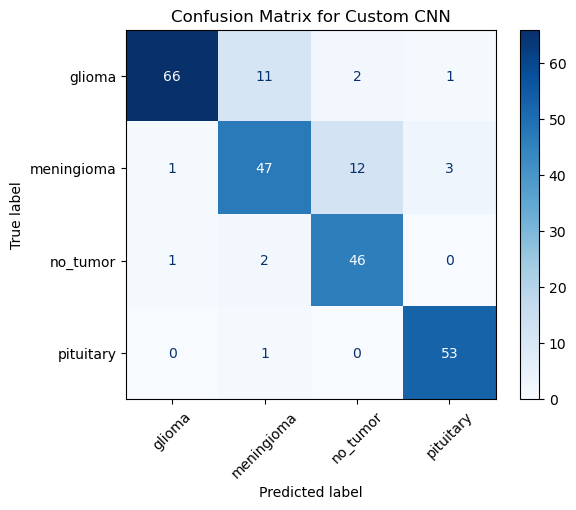

In [8]:
# Custom CNN
cnn_model = build_custom_cnn_model()
train_and_evaluate(cnn_model, "Custom CNN", train_data, validation_data, test_data, 10)


--- Training ResNet-50 ---
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.3592 - loss: 1.3702  
Epoch 1: val_loss improved from None to 1.25089, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.4130 - loss: 1.3099 - val_accuracy: 0.3207 - val_loss: 1.2509
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.4581 - loss: 1.2213
Epoch 2: val_loss improved from 1.25089 to 1.17529, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.5186 - loss: 1.1894 - val_accuracy: 0.4900 - val_loss: 1.1753
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.5225 - loss: 1.1375  
Epoch 3: val_loss improved from 1.17529 to 1.13084, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.5386 - loss: 1.1363 - val_accuracy: 0.4821 - val_loss: 1.1308
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.5780 - loss: 1.0944  
Epoch 4: val_loss improved from 1.13084 to 1.05673, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.6047 - loss: 1.0668 - val_accuracy: 0.5578 - val_loss: 1.0567
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.6414 - loss: 1.0292  
Epoch 5: val_loss improved from 1.05673 to 1.04462, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6260 - loss: 1.0337 - val_accuracy: 0.5876 - val_loss: 1.0446
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.6390 - loss: 1.0193  
Epoch 6: val_loss improved from 1.04462 to 1.01798, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6372 - loss: 1.0049 - val_accuracy: 0.5498 - val_loss: 1.0180
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.5999 - loss: 1.0074  
Epoch 7: val_loss improved from 1.01798 to 0.97314, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.6319 - loss: 0.9775 - val_accuracy: 0.6534 - val_loss: 0.9731
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6517 - loss: 0.9736  
Epoch 8: val_loss improved from 0.97314 to 0.96230, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.6501 - loss: 0.9658 - val_accuracy: 0.5876 - val_loss: 0.9623
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6410 - loss: 0.9464  
Epoch 9: val_loss improved from 0.96230 to 0.94907, saving model to models/ResNet-50_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.6490 - loss: 0.9553 - val_accuracy: 0.6454 - val_loss: 0.9491
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.6616 - loss: 0.9178  
Epoch 10: val_loss did not improve from 0.94907
106/106 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6631 - loss: 0.9220 - val_accuracy: 0.5956 - val_loss: 0.9494
Restoring model weights from the end of the best epoch: 9.


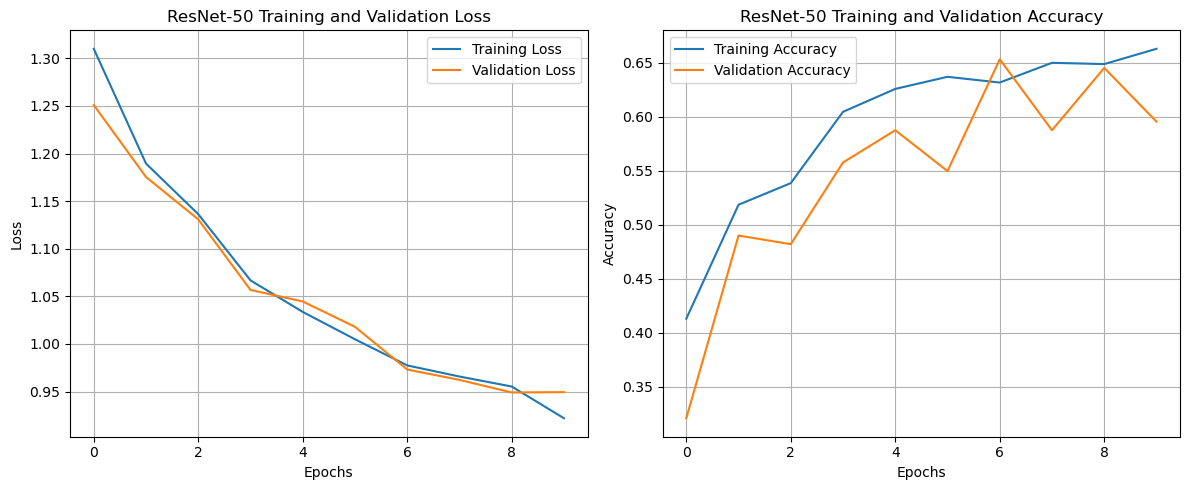


--- Evaluating ResNet-50 on Test Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 809ms/step - accuracy: 0.6870 - loss: 0.8988

Test Accuracy: 68.70%
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 983ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.67      0.82      0.74        80
  meningioma       0.73      0.35      0.47        63
    no_tumor       0.81      0.59      0.68        49
   pituitary       0.63      0.96      0.76        54

    accuracy                           0.69       246
   macro avg       0.71      0.68      0.67       246
weighted avg       0.71      0.69      0.67       246



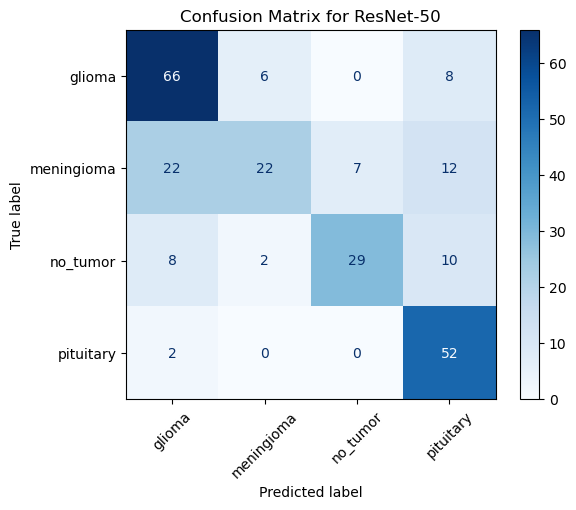

In [13]:
# ResNet-50
resnet_model = build_transfer_model(ResNet50)
train_and_evaluate(resnet_model, "ResNet-50", train_data, validation_data, test_data, 10)


--- Training MobileNet-V2 ---


C:\Users\SDP87\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.6236 - loss: 0.9423 
Epoch 1: val_loss improved from None to 0.49139, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 66s 579ms/step - accuracy: 0.7422 - loss: 0.6848 - val_accuracy: 0.8287 - val_loss: 0.4914
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8678 - loss: 0.3859 
Epoch 2: val_loss improved from 0.49139 to 0.41256, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 566ms/step - accuracy: 0.8678 - loss: 0.3812 - val_accuracy: 0.8466 - val_loss: 0.4126
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9032 - loss: 0.3061 
Epoch 3: val_loss improved from 0.41256 to 0.36625, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 564ms/step - accuracy: 0.8867 - loss: 0.3214 - val_accuracy: 0.8825 - val_loss: 0.3662
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.9047 - loss: 0.2853 
Epoch 4: val_loss did not improve from 0.36625
106/106 ━━━━━━━━━━━━━━━━━━━━ 58s 551ms/step - accuracy: 0.9121 - loss: 0.2734 - val_accuracy: 0.8625 - val_loss: 0.3751
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9092 - loss: 0.2581 
Epoch 5: val_loss improved from 0.36625 to 0.33283, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 560ms/step - accuracy: 0.9068 - loss: 0.2663 - val_accuracy: 0.8785 - val_loss: 0.3328
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9228 - loss: 0.2303 
Epoch 6: val_loss improved from 0.33283 to 0.31438, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 557ms/step - accuracy: 0.9192 - loss: 0.2430 - val_accuracy: 0.8944 - val_loss: 0.3144
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.9326 - loss: 0.2138 
Epoch 7: val_loss did not improve from 0.31438
106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 555ms/step - accuracy: 0.9310 - loss: 0.2180 - val_accuracy: 0.8645 - val_loss: 0.3634
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9464 - loss: 0.1868 
Epoch 8: val_loss did not improve from 0.31438
106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 560ms/step - accuracy: 0.9345 - loss: 0.2016 - val_accuracy: 0.8845 - val_loss: 0.3200
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9411 - loss: 0.1911 
Epoch 9: val_loss improved from 0.31438 to 0.30618, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 59s 559ms/step - accuracy: 0.9422 - loss: 0.1930 - val_accuracy: 0.8924 - val_loss: 0.3062
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.9529 - loss: 0.1723 
Epoch 10: val_loss improved from 0.30618 to 0.28747, saving model to models/MobileNet-V2_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 57s 540ms/step - accuracy: 0.9487 - loss: 0.1747 - val_accuracy: 0.8924 - val_loss: 0.2875
Restoring model weights from the end of the best epoch: 10.


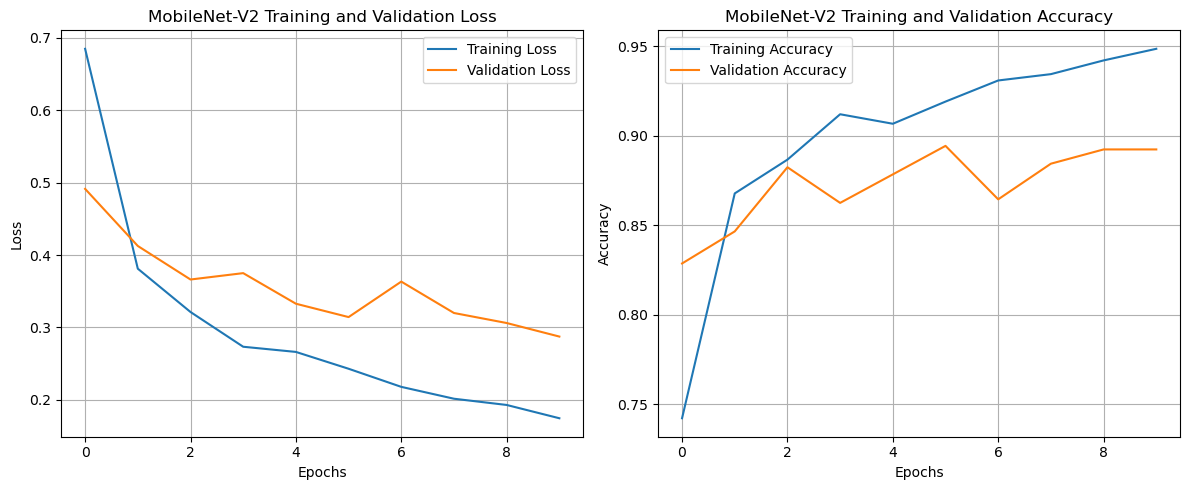


--- Evaluating MobileNet-V2 on Test Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.8333 - loss: 0.4037

Test Accuracy: 83.33%
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.87      0.91      0.89        80
  meningioma       0.80      0.63      0.71        63
    no_tumor       0.90      0.78      0.84        49
   pituitary       0.77      1.00      0.87        54

    accuracy                           0.83       246
   macro avg       0.84      0.83      0.83       246
weighted avg       0.84      0.83      0.83       246



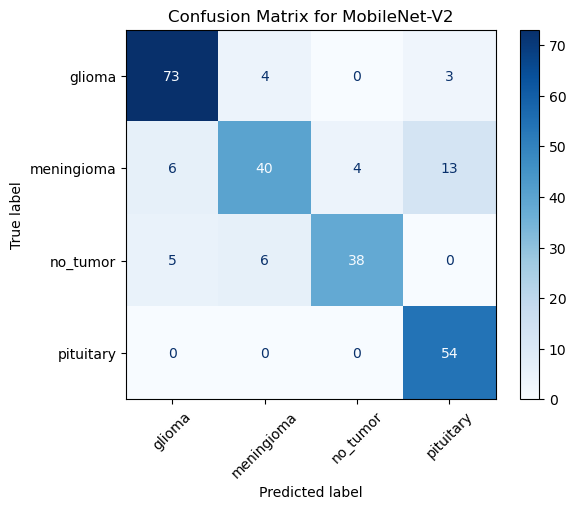

In [12]:
# MobileNet-V2
mobilenet_model = build_transfer_model(MobileNetV2)
train_and_evaluate(mobilenet_model, "MobileNet-V2", train_data, validation_data, test_data, 10)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step

--- Training EfficientNet-B0 ---
Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.3106 - loss: 1.3921
Epoch 1: val_loss improved from inf to 1.38454, saving model to models/EfficientNet-B0_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 54s 432ms/step - accuracy: 0.3106 - loss: 1.3921 - val_accuracy: 0.3207 - val_loss: 1.3845
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.3002 - loss: 1.3814
Epoch 2: val_loss improved from 1.38454 to 1.37404, saving model to models/EfficientNet-B0_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 44s 413ms/step - accuracy: 0.3002 - loss: 1.3814 - val_accuracy: 0.3207 - val_loss: 1.3740
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3010 - loss: 1.3797
Epoch 3: val_loss did not improve from 1.37404
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.3010 - loss: 1.3796 - val_accuracy: 0.3207 - val_loss: 1.4035
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.3227 - loss: 1.3782
Epoch 4: val_loss did not improve from 1.37404
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 408ms/step - accuracy: 0.3225 - loss: 1.3783 - val_accuracy: 0.3207 - val_loss: 1.3751
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3330 - loss: 1.3684
Epoch 5: val_loss improved from 1.37404 to 1.37182, saving model to models/EfficientNet-B0_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 403ms/step - accuracy: 0.3329 - loss: 1.3685 - val_accuracy: 0.3207 - val_loss: 1.3718
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3063 - loss: 1.3800
Epoch 6: val_loss did not improve from 1.37182
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 401ms/step - accuracy: 0.3064 - loss: 1.3800 - val_accuracy: 0.3207 - val_loss: 1.3952
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.3047 - loss: 1.3861
Epoch 7: val_loss improved from 1.37182 to 1.37005, saving model to models/EfficientNet-B0_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 407ms/step - accuracy: 0.3047 - loss: 1.3860 - val_accuracy: 0.3207 - val_loss: 1.3701
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3342 - loss: 1.3710
Epoch 8: val_loss did not improve from 1.37005
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 401ms/step - accuracy: 0.3340 - loss: 1.3710 - val_accuracy: 0.3207 - val_loss: 1.3953
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.3101 - loss: 1.3835
Epoch 9: val_loss did not improve from 1.37005
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 402ms/step - accuracy: 0.3101 - loss: 1.3835 - val_accuracy: 0.3307 - val_loss: 1.3710
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3019 - loss: 1.3780
Epoch 10: val_loss did not improve from 1.37005
106/106 ━━━━━━━━━━━━━━━━━━━━ 42s 400ms/step - accuracy: 0.3019 - loss: 1.3780 - val_accuracy: 0.3207 - val_loss: 1.3784
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.


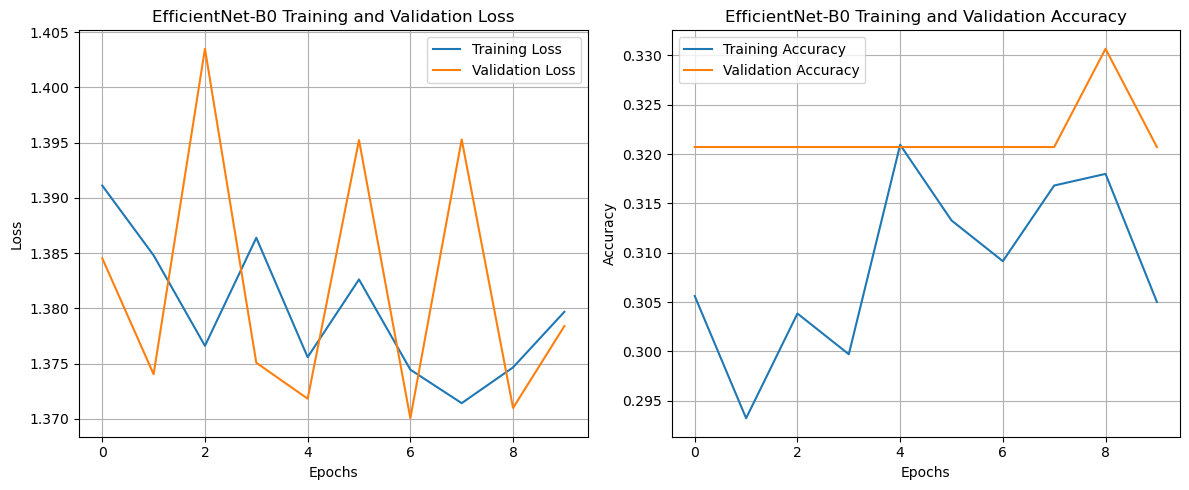


--- Evaluating EfficientNet-B0 on Test Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.6368 - loss: 1.2451

Test Accuracy: 32.52%
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


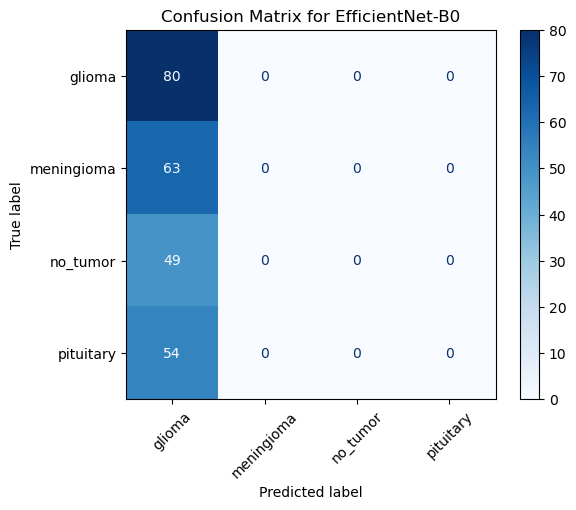

In [12]:
# EfficientNet-B0
efficientnet_model = build_transfer_model(EfficientNetB0)
train_and_evaluate(efficientnet_model, "EfficientNet-B0", train_data, validation_data, test_data, 10)

In [10]:
# InceptionV3 requires a specific input size
def build_inception_model():
    """Builds InceptionV3 model with a custom top classifier."""
    base_model = InceptionV3(input_shape=(299,299,3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(4, activation='softmax')
    ])
    return model

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.

--- Training InceptionV3 ---


C:\Users\SDP87\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5833 - loss: 0.9849  
Epoch 1: val_loss improved from None to 0.51040, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.7068 - loss: 0.7456 - val_accuracy: 0.8187 - val_loss: 0.5104
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8321 - loss: 0.4796  
Epoch 2: val_loss improved from 0.51040 to 0.44848, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8383 - loss: 0.4525 - val_accuracy: 0.8486 - val_loss: 0.4485
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8680 - loss: 0.3901  
Epoch 3: val_loss improved from 0.44848 to 0.41063, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.8808 - loss: 0.3631 - val_accuracy: 0.8546 - val_loss: 0.4106
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8715 - loss: 0.3473  
Epoch 4: val_loss improved from 0.41063 to 0.40183, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8867 - loss: 0.3292 - val_accuracy: 0.8685 - val_loss: 0.4018
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8982 - loss: 0.3081  
Epoch 5: val_loss improved from 0.40183 to 0.38081, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8973 - loss: 0.3041 - val_accuracy: 0.8546 - val_loss: 0.3808
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8749 - loss: 0.3044  
Epoch 6: val_loss improved from 0.38081 to 0.37772, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8909 - loss: 0.2986 - val_accuracy: 0.8745 - val_loss: 0.3777
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9041 - loss: 0.2681  
Epoch 7: val_loss improved from 0.37772 to 0.35486, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.9080 - loss: 0.2666 - val_accuracy: 0.8884 - val_loss: 0.3549
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9104 - loss: 0.2384  
Epoch 8: val_loss improved from 0.35486 to 0.33556, saving model to models/InceptionV3_best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.9127 - loss: 0.2474 - val_accuracy: 0.8865 - val_loss: 0.3356
Epoch 9/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9163 - loss: 0.2508  
Epoch 9: val_loss did not improve from 0.33556
106/106 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.9245 - loss: 0.2284 - val_accuracy: 0.8625 - val_loss: 0.3925
Epoch 10/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9227 - loss: 0.2235  
Epoch 10: val_loss did not improve from 0.33556
106/106 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9233 - loss: 0.2198 - val_accuracy: 0.8645 - val_loss: 0.3600
Restoring model weights from the end of the best epoch: 8.


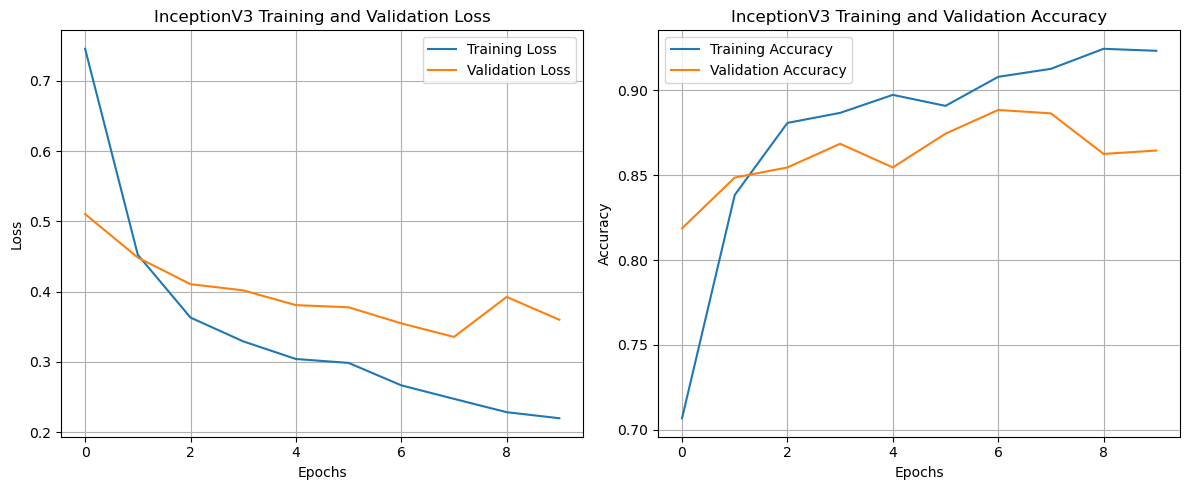


--- Evaluating InceptionV3 on Test Set ---
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.8618 - loss: 0.3941   

Test Accuracy: 86.18%
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.96      0.93        80
  meningioma       0.85      0.65      0.74        63
    no_tumor       0.87      0.82      0.84        49
   pituitary       0.81      1.00      0.89        54

    accuracy                           0.86       246
   macro avg       0.86      0.86      0.85       246
weighted avg       0.86      0.86      0.86       246



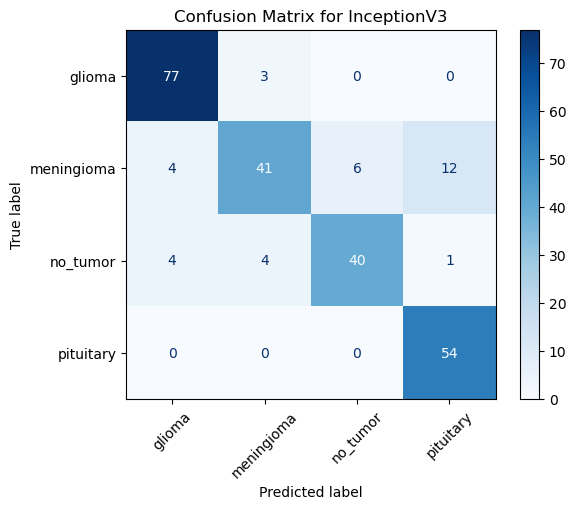

In [11]:
# InceptionV3
    # Keras InceptionV3 requires input_shape=(299, 299, 3)
    # The aux_logits output is not explicitly handled in the Keras Applications API
    # as the model is designed to produce a single classification output.
inception_train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)
inception_val_gen = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)
inception_test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

inception_model = build_inception_model()
train_and_evaluate(inception_model, "InceptionV3", inception_train_gen, inception_val_gen, inception_test_gen, 10)